# Diabete Classification

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pandas_profiling
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

# for visualisation
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns



from sklearn.model_selection import train_test_split, StratifiedKFold # helps us split the data
from sklearn import metrics # import the metrics we will use
import warnings



# import the models we will be using
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB, GaussianNB, MultinomialNB

warnings.filterwarnings(action='ignore')

/kaggle/input/pyms-diabete/diabete.csv


## Import the data

In [2]:
df = pd.read_csv("../input/pyms-diabete/diabete.csv")
df.head(7)

,n_pregnant,glucose,tension,thickness,insulin,bmi,pedigree,age,diabete
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
5,5,116,74,0,0,25.6,0.201,30,0
6,3,78,50,32,88,31.0,0.248,26,1


In [3]:
print("Shape of the data :{}".format(df.shape)) # shape of aour data
df.info() # gives us a general view of the data types

Shape of the data :(768, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
n_pregnant    768 non-null int64
glucose       768 non-null int64
tension       768 non-null int64
thickness     768 non-null int64
insulin       768 non-null int64
bmi           768 non-null float64
pedigree      768 non-null float64
age           768 non-null int64
diabete       768 non-null int64
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


We can already see that there are no missing values.

In [4]:
df.profile_report() # general overview of the data

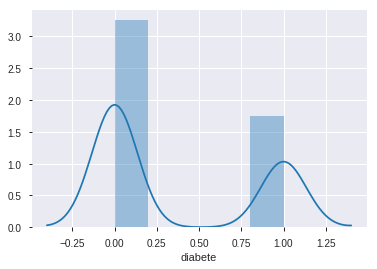

In [5]:
sns.distplot(df['diabete']) # distribution of our target variable
plt.show()

In [6]:
# Closer look of the count
print(df['diabete'].value_counts(ascending=False))

0    500
1    268
Name: diabete, dtype: int64


## Correlation

Let's take a look at the correlation between the features.

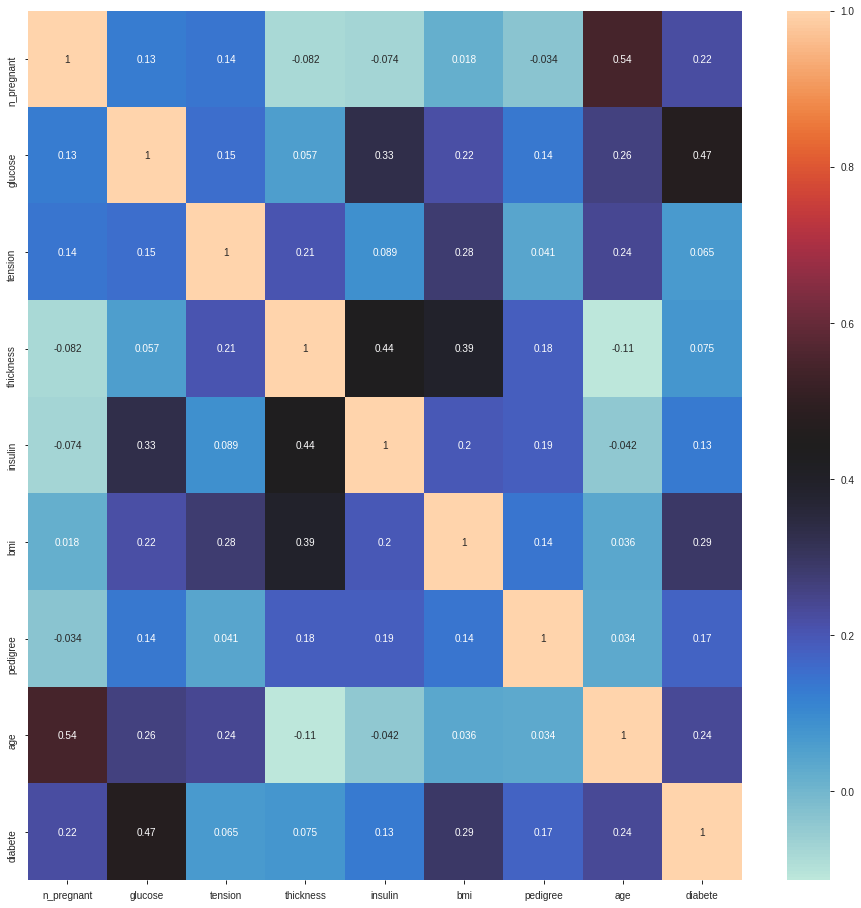

In [7]:
df_corr = df.corr()
plt.figure(figsize=(16,16))
sns.heatmap(df_corr, cmap='icefire', annot=True)

We have 6 features which are more or less correlated with the target.
Since we don't categorical features we can directly feed the data into our algorithm.
Next, we are going to take a closer look at the interaction between each feature by using the pairplot function from seaborn.

<Figure size 1152x1296 with 0 Axes>

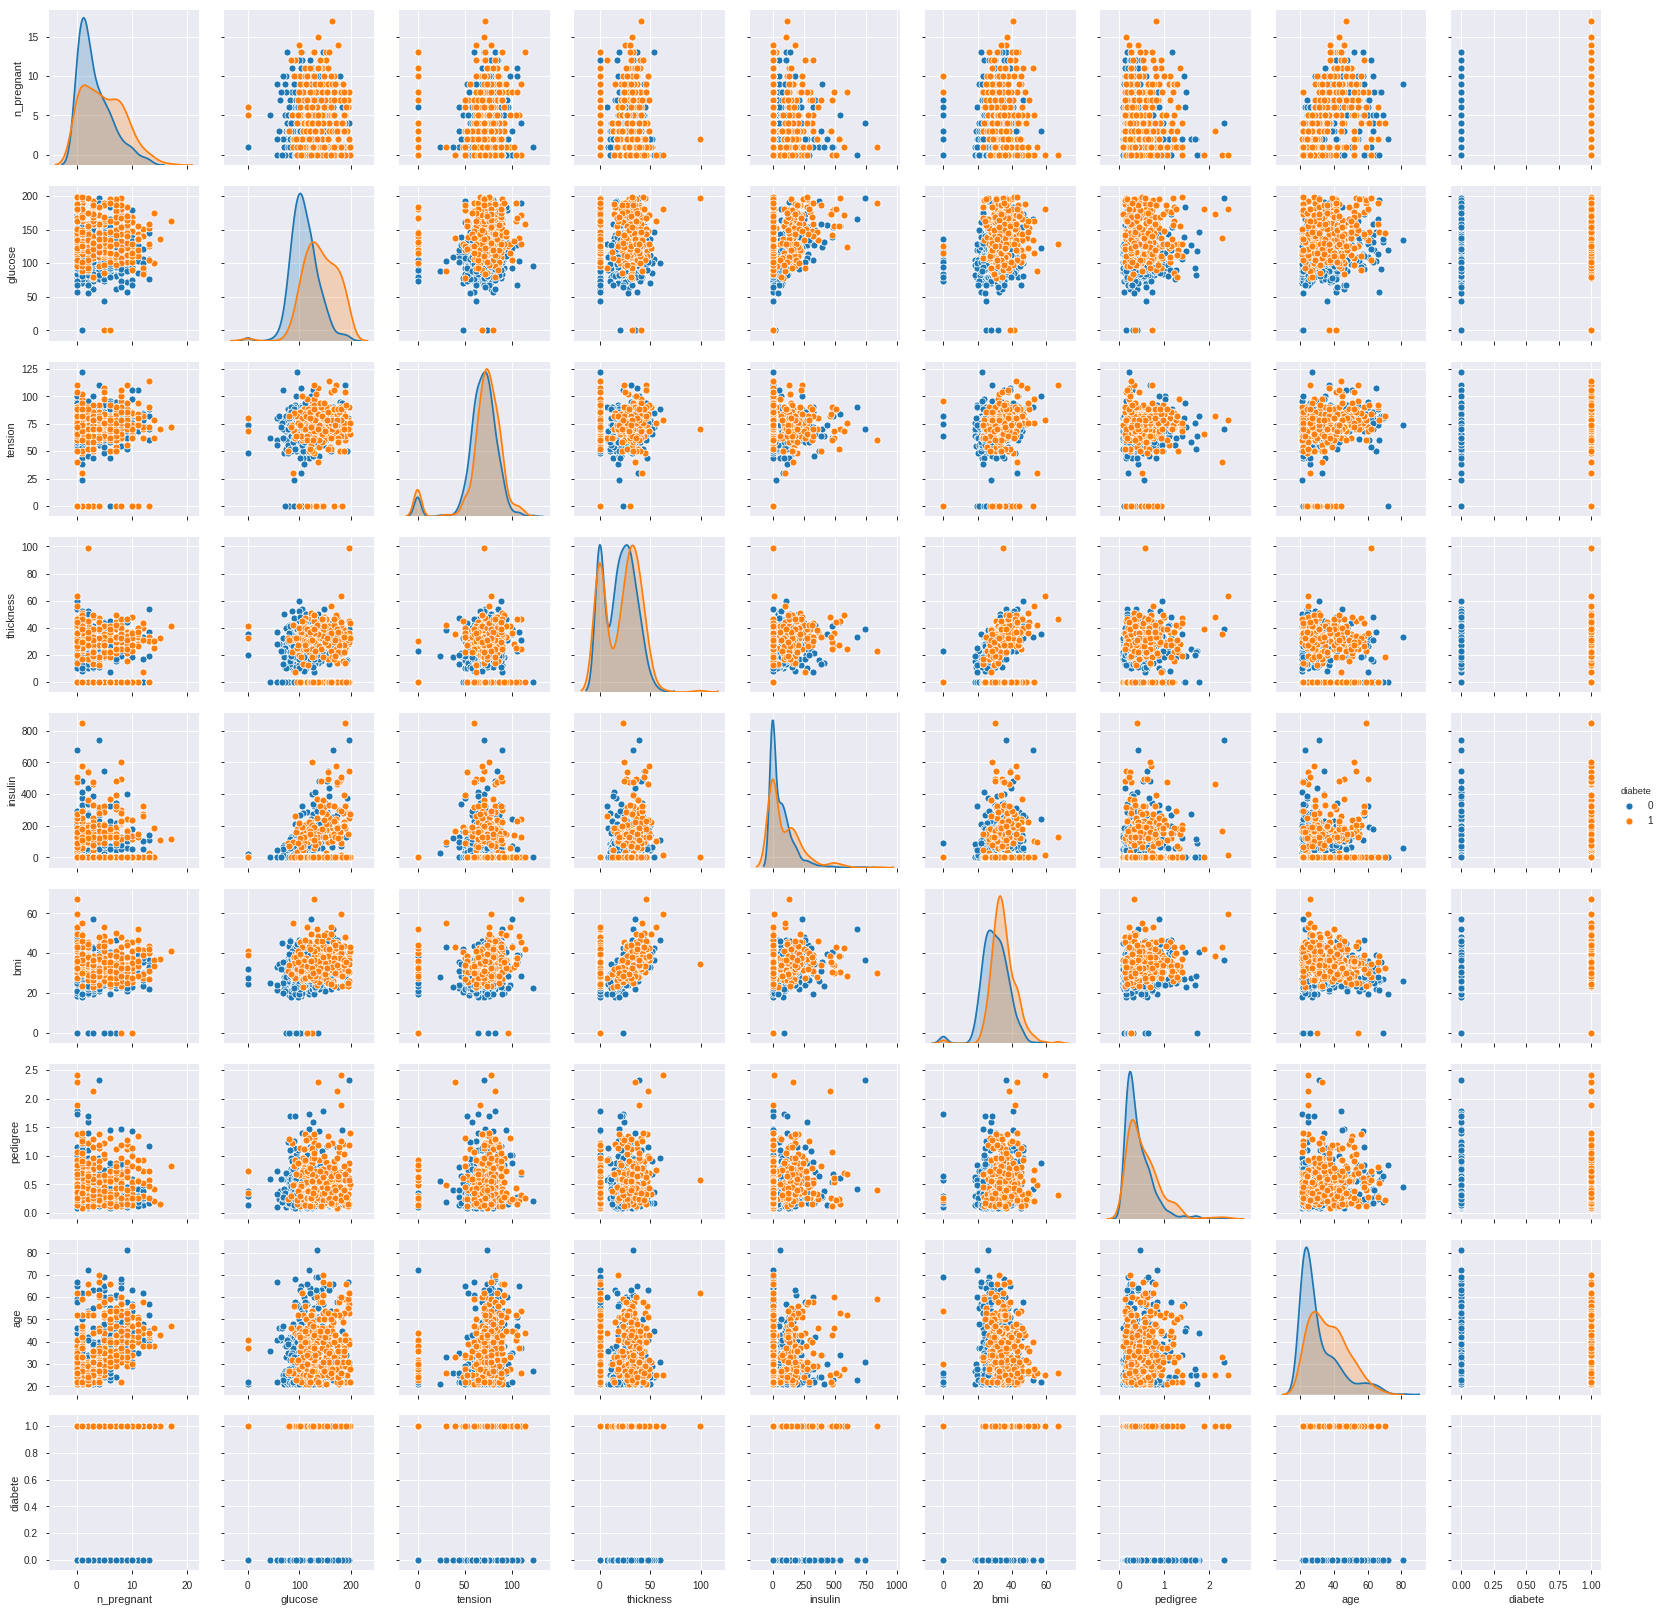

In [8]:
plt.figure(figsize=(16,18))
sns.pairplot(data=df, hue='diabete')

We can see some inapropriate values by looking at this plot. After some research I found out the minimal value for each feature.
It's not possible to have a 0 bmi(should be >=1) nor 0 tension(should be  >= 40)
nor a thickness equal to 0 (should be >5 depending on the sex)

From this plot, we can see that the vast majority of peaople suffering from Diabete have: -pregnant,
-higher BMI, higher g and two more other(confirmed by the correlation matrix)

## Directly feed the unpreprocessed data into an algorithm.

In [9]:
# Split the data
X = df.drop('diabete',1)
y = df[['diabete']]


'''we can definitely split the whole data into train, val and test sets. However, we are going to use Stratified
KFold class from sklearn which will generate random index from the data and preserve the percentage of samples
for each class'''

# use the stratify parameter in order to preserve the percentage of the class in each fold
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, stratify=y_train, random_state=42)

# print("Train size-\tX: {}\ty: {}".format(X_train.shape, y_train.shape))
# print("Valid size-\tX: {}\ty: {}".format(X_val.shape, y_val.shape))
# print("Test size-\tX: {}\ty: {}".format(X_test.shape, y_test.shape))


def validation_and_test_score(model, X_train=X_train, y_train=y_train, X_test=X_test,
                              y_test=y_test, epochs=5):
    '''Helper function'''
    # validation strategy using stratified KFold
    kf = StratifiedKFold(n_splits = epochs, shuffle = True, random_state = 42) 
    # y_oof = np.zeros(X_train.shape[0]).astype('object')
    pred = np.zeros(X_test.shape[0]).astype('object')
    i = 0
    val_score = []
    for tr_idx, val_idx in kf.split(X_train, y_train):
        clf = model
        X_tr, X_vl = X_train.iloc[tr_idx, :], X_train.iloc[val_idx, :]
        y_tr, y_vl = y_train.iloc[tr_idx], y_train.iloc[val_idx]
        clf.fit(X_tr, y_tr)
        y_pred_proba = clf.predict_proba(X_vl)[:, 1]
        # y_oof[val_idx] = y_pred_proba
        val_score.append(metrics.roc_auc_score(y_vl, y_pred_proba))
        print("Val AUC Fold # " + str(i) + ": " + str(val_score[i]))
        pred += clf.predict_proba(X_test)[:, 1] / epochs
        i += 1 
    print("Validation AUC (mean) :\t{}".format(np.mean(val_score)))
    print("Test AUC :\t{}".format(metrics.roc_auc_score(y_test, pred)))
    

log_reg = LogisticRegression(solver='liblinear',random_state=42)
validation_and_test_score(log_reg)

Val AUC Fold # 0: 0.8119186046511628
Val AUC Fold # 1: 0.8476744186046512
Val AUC Fold # 2: 0.8334302325581395
Val AUC Fold # 3: 0.7770348837209303
Val AUC Fold # 4: 0.8520833333333334
Validation AUC (mean) :	0.8244282945736435
Test AUC :	0.8261111111111111


without any data preprocessing(**raw data**), we got an AUC score of **0.8261** on the test set and **0.8244** on the validation set which are not that bad. Let's see if we can get a better one. <br> 
Since we are talking about health here, it is really important to se how the model behave, let's see the confusion matrix for more details

#### Confusion matrix

In [10]:
def conf_matrix(model, X_test=X_test, y_test=y_test):
    '''Helper function'''
    y_pred = model.predict(X_test)
    print(metrics.confusion_matrix(y_test, y_pred))

In [11]:
conf_matrix(log_reg)

[[84 16]
 [28 26]]


84 are classified as really negative <br>
26 are classified as really positive<br>
16 are classified as positive but are actually negative<br>
28 are classified as negative but are actually positive<br>

There are 28 people classified as non diabetic but actually are. This is not acceptable as diabete is konwn to be one of the most dangerous diseases. We can try to tweak the threashold depending on the result we want.

## Feature engineering

In [12]:
def add_feats(df_entry):
    df = df_entry.copy()
    
    # apply log transformation to skewed features (did not work)
    # df['logPregnant'] = df['Pregnant'].apply(np.log1p)
    # df['logInsuline-2H'] = df['Insuline-2H'].apply(np.log1p)
        #     df['logPedigree'] = df['Pedigree'].apply(np.log) # use log because minimal value > 0
#     df['logTriceps'] = df['Triceps'].apply(np.log1p)
    
    #categorise feature to better capture their meaning
    df['categBloodPressure'] = pd.cut(df['tension'], bins=5, labels=["normal", "elevated", "high1",
                                                                      "high2", "hyper"])
    df['categAge'] = pd.cut(df['age'], bins=7, labels=['20s','30s','40s','50s','60s','70s','80s'],
                            include_lowest=True)
    bmiBins = [1, 18.5, 24.9, 29.9, np.inf]
    df['catBMI'] = pd.cut(df['bmi'], bins=bmiBins, labels=["under","normal","over", "obese"])

    res_df = pd.get_dummies(df, columns=['categBloodPressure','catBMI','categAge'], drop_first=True)
#     res_df = pd.concat([df, dummies], axis=1)
    
    cols_to_drop = ['tension', 'bmi', 'age']
    res_df = res_df.drop(cols_to_drop, axis=1)
    return res_df

In [13]:
new_df = add_feats(df)
print(new_df.shape)
new_df.info()

(768, 19)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 19 columns):
n_pregnant                     768 non-null int64
glucose                        768 non-null int64
thickness                      768 non-null int64
insulin                        768 non-null int64
pedigree                       768 non-null float64
diabete                        768 non-null int64
categBloodPressure_elevated    768 non-null uint8
categBloodPressure_high1       768 non-null uint8
categBloodPressure_high2       768 non-null uint8
categBloodPressure_hyper       768 non-null uint8
catBMI_normal                  768 non-null uint8
catBMI_over                    768 non-null uint8
catBMI_obese                   768 non-null uint8
categAge_30s                   768 non-null uint8
categAge_40s                   768 non-null uint8
categAge_50s                   768 non-null uint8
categAge_60s                   768 non-null uint8
categAge_70s                   76

In [14]:
new_df.head(7)

,n_pregnant,glucose,thickness,insulin,pedigree,diabete,categBloodPressure_elevated,categBloodPressure_high1,categBloodPressure_high2,categBloodPressure_hyper,catBMI_normal,catBMI_over,catBMI_obese,categAge_30s,categAge_40s,categAge_50s,categAge_60s,categAge_70s,categAge_80s
0,6,148,35,0,0.627,1,0,1,0,0,0,0,1,0,0,1,0,0,0
1,1,85,29,0,0.351,0,0,1,0,0,0,1,0,1,0,0,0,0,0
2,8,183,0,0,0.672,1,0,1,0,0,1,0,0,1,0,0,0,0,0
3,1,89,23,94,0.167,0,0,1,0,0,0,1,0,0,0,0,0,0,0
4,0,137,35,168,2.288,1,1,0,0,0,0,0,1,1,0,0,0,0,0
5,5,116,0,0,0.201,0,0,0,1,0,0,1,0,1,0,0,0,0,0
6,3,78,32,88,0.248,1,0,1,0,0,0,0,1,0,0,0,0,0,0


## Feed the data after feature engineering into an algorithm

In [15]:
X = new_df.drop('diabete',1)
y = new_df[['diabete']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)

log_reg = LogisticRegression(solver='liblinear',random_state=42)
validation_and_test_score(log_reg, X_train, y_train, X_test, y_test)

Val AUC Fold # 0: 0.8101744186046511
Val AUC Fold # 1: 0.8209302325581396
Val AUC Fold # 2: 0.8404069767441861
Val AUC Fold # 3: 0.7944767441860465
Val AUC Fold # 4: 0.8973214285714286
Validation AUC (mean) :	0.8326619601328904
Test AUC :	0.8390740740740741


With feature engineering our AUC on the test set went from **0.8261** to **0.8390** which is not a big boost but still good.

## Outlier detection

There are many ways to detect outliers in a dataset.
Here we are going to tackle the outliers in the original DataFrame and see if it can improve our previous performance.

#### List of the most correlated features

In [16]:
out_df = df.copy() # Original DataFrame containing outliers
corr_df = out_df.corr()
selected_features = corr_df[corr_df['diabete']>=0.13].index.drop('diabete').tolist()
print("Selected Features by the correlation Test: \n")
print(selected_features)

Selected Features by the correlation Test: 

['n_pregnant', 'glucose', 'insulin', 'bmi', 'pedigree', 'age']


### Box plot of the features

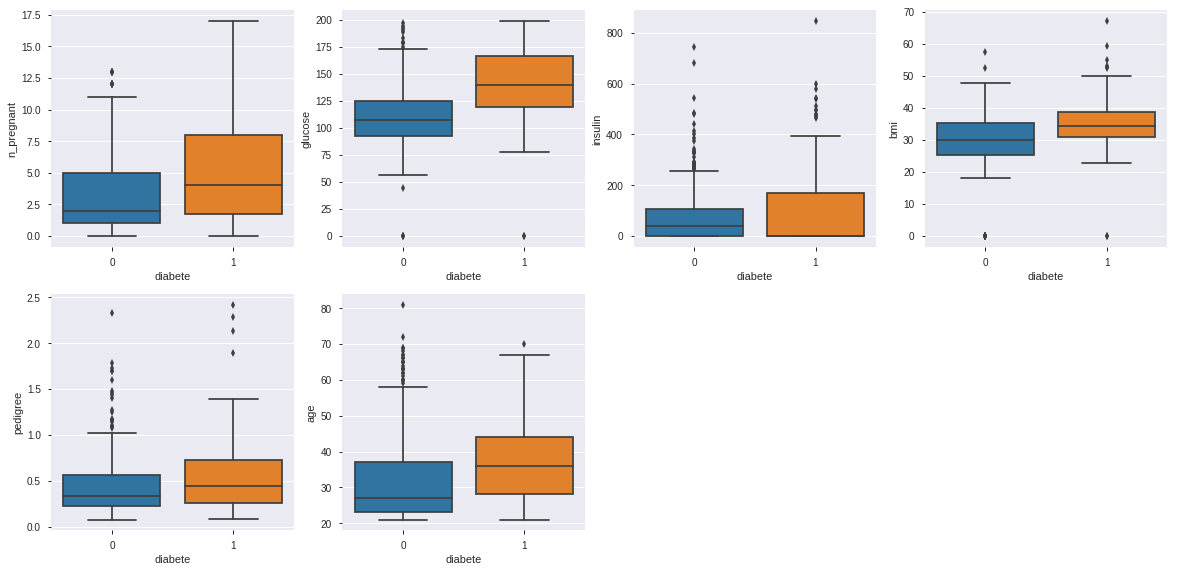

In [17]:
axis = []
figure = plt.figure(figsize=(20,20))
x=1
for c in selected_features:
    axis.append(figure.add_subplot(4,4,x))
    sns.boxplot(y=c, x='diabete', data=out_df, ax=axis[-1])
    x+=1
plt.show()

We are going to define a helper function which will help us detect and delete or replace the outliers

In [18]:
def detect_delete_outlier(f, df, delete_out=False, replace_out=False):
    '''Helper function to detecte outliers'''
    res_df = None
    s = df[f] #the feature
    q25, q75 = np.percentile(s, 25), np.percentile(s, 75)
    inter_range = q75 - q25 #interquartile range
    step = 1.5*inter_range
    lower, upper = q25 - step, q75 + step
    outliers = [x for x in s if x < lower or x > upper] # list of outlier
    isOutlier = [True if x < lower or x > upper else False for x in s] # mask
    
    if delete_out==True:
        res_def = df.drop(df[(s < lower) | (s > upper)].index) # drop the outliers
    elif replace_out==True:
        df.loc[isOutlier, f] = df[f].median() #locate outliers and replace them with the median
        res_def = df.copy()
    return res_def, outliers

### Feed the cleaned original data into an algorithm

#### a- delete the outliers
After deleting the outliers, We are going to feed the cleaned original data(witout feature engineering) into a model.

In [19]:
#detecte and delete outliers in original df
df_with_out = out_df.copy()
for c in selected_features:
    res_df, _ = detect_delete_outlier(c, df_with_out, delete_out=True)
print("featured df shape: {}".format(df.shape))
print("cleaned df shape: {}".format(res_df.shape))

featured df shape: (768, 9)
cleaned df shape: (759, 9)


In [20]:
X = res_df.drop('diabete',1)
y = res_df[['diabete']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)

log_reg = LogisticRegression(solver='liblinear',random_state=42)
validation_and_test_score(log_reg, X_train, y_train, X_test, y_test)

Val AUC Fold # 0: 0.8457462466882544
Val AUC Fold # 1: 0.7753900500441566
Val AUC Fold # 2: 0.8104209596702973
Val AUC Fold # 3: 0.8893911995177819
Val AUC Fold # 4: 0.8287545787545787
Validation AUC (mean) :	0.8299406069350137
Test AUC :	0.8023632551934439


By deleting the ouliers, we got an AUC of **0.8023** on the test set an **0.8299** on the validation set, it indicates an overfitting model.<br>
Compared to **0.8261** on the test set obtained by using the original raw data.

#### b- replace the outliers

In [21]:
#detecte and replace outliers in original df
df_with_out = out_df.copy()
for c in selected_features:
    res_df, _ = detect_delete_outlier(c, df_with_out, replace_out=True)
print("featured df shape: {}".format(df.shape))
print("cleaned df shape: {}".format(res_df.shape))

featured df shape: (768, 9)
cleaned df shape: (768, 9)


In [22]:
X = res_df.drop('diabete',1)
y = res_df[['diabete']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)

log_reg = LogisticRegression(solver='liblinear',random_state=42)
validation_and_test_score(log_reg, X_train, y_train, X_test, y_test)

Val AUC Fold # 0: 0.8334302325581395
Val AUC Fold # 1: 0.8209302325581396
Val AUC Fold # 2: 0.8316860465116279
Val AUC Fold # 3: 0.7805232558139534
Val AUC Fold # 4: 0.8666666666666667
Validation AUC (mean) :	0.8266472868217054
Test AUC :	0.8125925925925925


By replacing the ouliers, we got an AUC of **0.8125** on the test set an **0.8266** on the validation set<br>
Compared to **0.8261** on the test set obtained by using the original raw data.

So far the best AUC we got was around **0.8390** after feature engineering.<br>

Maybe we should try to tackle these instances considered as outliers one by one. For example by replacing the 0 with the appropriate values.<br>
**bmi, tension, thickness, glucose** shoud not take a 0 a value

## Rectify the inappropriate values

In [23]:
dfcopy = df.copy()
dfcopy['bmi'] = dfcopy['bmi'].apply(lambda x: 1 if x < 1 else x)
dfcopy['tension'] = dfcopy['tension'].apply(lambda x: 40 if x < 40 else x)
dfcopy['thickness'] = dfcopy['thickness'].apply(lambda x: 5.5 if x < 5.5 else x )
dfcopy.head(20)

,n_pregnant,glucose,tension,thickness,insulin,bmi,pedigree,age,diabete
0,6,148,72,35.0,0,33.6,0.627,50,1
1,1,85,66,29.0,0,26.6,0.351,31,0
2,8,183,64,5.5,0,23.3,0.672,32,1
3,1,89,66,23.0,94,28.1,0.167,21,0
4,0,137,40,35.0,168,43.1,2.288,33,1
5,5,116,74,5.5,0,25.6,0.201,30,0
6,3,78,50,32.0,88,31.0,0.248,26,1
7,10,115,40,5.5,0,35.3,0.134,29,0
8,2,197,70,45.0,543,30.5,0.158,53,1
9,8,125,96,5.5,0,1.0,0.232,54,1


## Directly feed this rectified data to an algorithm

In [24]:
X = dfcopy.drop('diabete',1)
y = dfcopy[['diabete']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)

log_reg = LogisticRegression(solver='liblinear',random_state=42)
validation_and_test_score(log_reg, X_train, y_train, X_test, y_test)

Val AUC Fold # 0: 0.8093023255813954
Val AUC Fold # 1: 0.8421511627906976
Val AUC Fold # 2: 0.8337209302325582
Val AUC Fold # 3: 0.7811046511627907
Val AUC Fold # 4: 0.8419642857142857
Validation AUC (mean) :	0.8216486710963455
Test AUC :	0.8300000000000001


When we first used the **raw** data earlier, we got an AUC of **0.8261** on the test set, and **now** we obteind **0.83** on the test set, without any other preprocessing.

Let's apply **feature engineering** to this rectified data set.

In [25]:
new_df_2 = add_feats(dfcopy)

X = new_df_2.drop('diabete',1)
y = new_df_2[['diabete']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)

log_reg = LogisticRegression(solver='liblinear',random_state=42)
validation_and_test_score(log_reg, X_train, y_train, X_test, y_test)

Val AUC Fold # 0: 0.8186046511627907
Val AUC Fold # 1: 0.8090116279069768
Val AUC Fold # 2: 0.8433139534883721
Val AUC Fold # 3: 0.8005813953488372
Val AUC Fold # 4: 0.8928571428571429
Validation AUC (mean) :	0.8328737541528239
Test AUC :	0.8422222222222222


As we can see, by applying feature engineering on the new dataset we went from **0.8390(feature engineering on unrectified raw data)** to **0.8422**.
Finally, let's take a glimpse at the confusion matrix of our last classifier.

#### Confusion matrix

In [26]:
pred = log_reg.predict(X_test)
print(metrics.confusion_matrix(y_test, pred))

[[85 15]
 [24 30]]


We can see that:<br>
85 people are classified as really negative (84 before)<br>
30 people are classified as really positive (26 before)<br>
15 are classified as positive but are actually negative (16 before)<br>
24 are classified as negative but are actually positive (28 before)<br>

We can see that only by rectifying inappropriate values, the model classified 24 people to be non diabetic but actually are (28 before). Of course 24 people are still many but this shows the importance of diving into the values of the features we are given.
We could do a more specific adjustment to the values of our features if we had access to the gender of each person.
We can try many things in order to improve this result. For example, fine tune the model by tweaking the hyperparameters or tweak the threashold depending on the result we want.